Author: Adelson Araujo jr (adelsondias@gmail.com)

In [1]:
import sys
sys.path.append('/home/adelsondias/Repos/sensingbee')

import sensingbee

import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Data loading

   - From 1st January to 31st March
   - Daily sampled aggregated by median

In [2]:
data = sensingbee.data_preparation.Data('/home/adelsondias/Repos/sensingbee/examples/newcastle/data/weekly',
                                       grid_resolution=0.5)

In [3]:
data.samples.sample(5)

Value
Variable Sensor Name            Timestamp             
NO2      PER_EMOTE_2798         2019-01-20   52.836050
         PER_AIRMON_MESH1957150 2019-03-17   19.288800
PM2.5    PER_AIRMON_MESH1909150 2019-02-10    5.699000
CO       PER_EMOTE_1701         2019-03-10  337.940799
PM2.5    PER_AIRMON_MESH1917150 2019-03-10    0.970000

In [4]:
data.samples.groupby('Variable').size()

Variable
CO              871
Humidity       1232
NO2            1109
PM2.5           353
Temperature    1372
dtype: int64

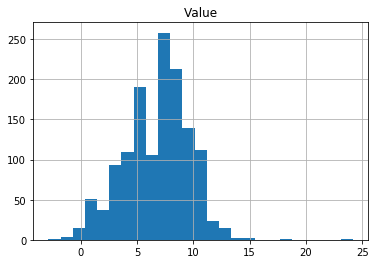

In [5]:
data.samples.loc['Temperature'].hist(bins=25);

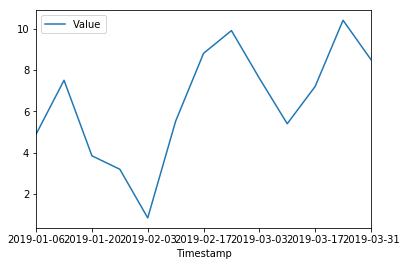

In [6]:
data.samples.loc['Temperature'].groupby('Timestamp').median().plot()

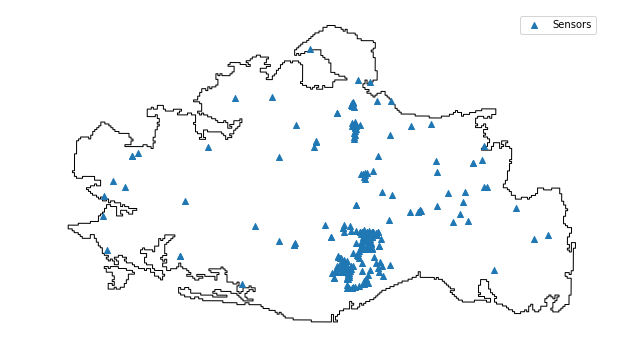

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

data.city.plot(ax=ax, color='white', edgecolor='black')
data.metadata.plot(ax=ax, marker='^', label='Sensors')

ax.legend()
ax.axis('off');

# Feature engineering

I'm extracting IDW estimates for the locations where I have sensors (not considering the sensor itself), and using them as features to predict a variable. Actually, I do IDW for each time window (in this case for each week).

For instance, to predict `Temperature`, I'm using IDW of all the other variables in each week, as follows:

In [11]:
%%time

X_idw, y = sensingbee.feature_engineering.Features(variable='Temperature',
    method='idw', p=2, threshold=10/69).transform(data.samples, data.metadata)

CPU times: user 42.7 s, sys: 32.3 ms, total: 42.7 s
Wall time: 42.7 s


In [12]:
X_idw.head()

CO   Humidity         NO2  Temperature  \
Sensor Name    Timestamp                                                    
PER_EMOTE_1410 2019-01-06  325.026968  74.625476  179.370106     5.403557   
               2019-01-13  341.773807  78.866602   73.857121     7.921434   
               2019-01-20  358.770874  79.952413   36.712869     4.578623   
               2019-01-27  289.407748  83.033654   39.115235     3.955252   
               2019-02-03  320.619858  85.134256   58.450531     1.498411   

                              PM2.5  
Sensor Name    Timestamp             
PER_EMOTE_1410 2019-01-06  5.089313  
               2019-01-13  2.523793  
               2019-01-20  3.292710  
               2019-01-27  4.421793  
               2019-02-03  4.030876

In [13]:
y.head()

Value
Sensor Name    Timestamp        
PER_EMOTE_1410 2019-01-06   5.40
               2019-01-13   7.90
               2019-01-20   4.60
               2019-01-27   3.95
               2019-02-03   1.40

# ML model

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = X_idw.sample(frac=1)
y = y.loc[X.index]

r2, mse = [], []
for train_index, test_index in KFold(10).split(X):
    model = GradientBoostingRegressor().fit(X.iloc[train_index], np.ravel(y.iloc[train_index]))
    y_pred = model.predict(X.iloc[test_index])
    r2.append( r2_score(y.iloc[test_index], y_pred) )
    mse.append( mean_squared_error(y.iloc[test_index], y_pred) )
    
print('R² =', np.mean(r2))
print('MSE =', np.mean(mse))

R² = 0.8434238358060663
MSE = 1.3392633843461528


In [15]:
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])

,importance
CO,0.009113
Humidity,0.021570
NO2,0.006756
Temperature,0.955685
PM2.5,0.006875


To predict, one should pass IDW estimates of arbitrary locations, such as points in a grid:

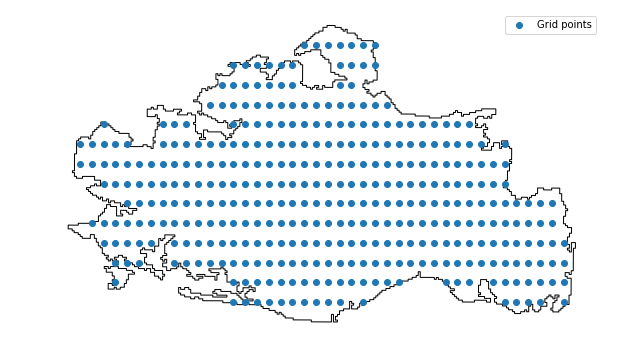

In [27]:
fig, ax = plt.subplots(figsize=(10,6))

data.city.plot(ax=ax, color='white', edgecolor='black')
data.grid.data.plot(ax=ax, marker='o', label='Grid points')

ax.legend()
ax.axis('off');

In [17]:
X_idw_grid, y = sensingbee.feature_engineering.Features(variable='Temperature',
    method='idw', p=2, threshold=10/69).transform(data.samples, data.metadata, data.grid.data)

In [18]:
idx = pd.IndexSlice
X_pred = X_idw_grid.loc[idx[:,'2019-03-31'],:]
y_pred = model.predict(X_pred)
y_pred = pd.DataFrame(y_pred, index=data.grid.data.index, columns=['Temperature'])
y_pred.head()

,Temperature
58,8.372735
59,8.266286
60,8.458614
61,8.665315
62,8.520493


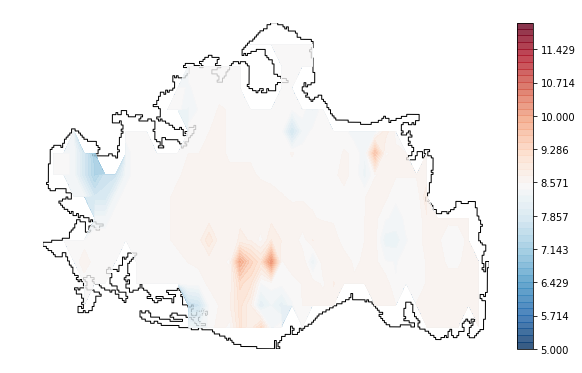

In [52]:
def plot_interpolation(shape, grid, vals, ax, scale=True, cmin=0, cmax=1, cmap='RdBu', fig_path=False, geojson_path=False):
    vals.index.name = 'place'
    Z = np.zeros(grid.lonv.shape[0]*grid.lonv.shape[1]) - 999
    if scale is True:
        from sklearn.preprocessing import MinMaxScaler
        Z[vals.reset_index()['place'].unique()] = MinMaxScaler().fit_transform(vals).ravel()
    elif scale is False:
        Z[vals.reset_index()['place'].unique()] = vals.values.ravel()
    else:
        Z[vals.reset_index()['place'].unique()] = scale.fit_transform(vals).ravel()
        cmin = scale.fit_transform(vals).ravel().min()
        cmax = scale.fit_transform(vals).ravel().max()
    Z = Z.reshape(grid.lonv.shape)
    shape.plot(ax=ax, color='white', edgecolor='black')
    contourf = plt.contourf(grid.lonv, grid.latv, Z, levels=np.linspace(cmin, cmax, 50), alpha=0.8, cmap=cmap)
    plt.axis('off')
    plt.colorbar()
    if fig_path:
        plt.savefig(fig_path)
    if geojson_path:
        import geojsoncontour
        geojsoncontour.contourf_to_geojson(contourf=contourf, geojson_filepath=geojson_path, fill_opacity=0.5)
    plt.show()
    return

fig, ax = plt.subplots(figsize=(10,6))
plot_interpolation(data.city, data.grid, y_pred, ax, scale=False, cmin=5, cmax=12, cmap='RdBu_r')


# Problems and Limitations


- Samples can have many outliers and harm this modeling (mainly the training phase), so a filtering criteria must be set, perhaps with predefined threshold;
- IDW for each time interval is a slow process that have to be made in both training and predicting phase with this modelling;
- Should one predict for all locations? Its fair to predict for non-urban places, where we don't have sensors nearby? Perhaps the urban/geogrhic distribution may bias the predictions, so a place filtering must be defined.